In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.linear_model import SGDOneClassSVM
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

from dataset import Dataset
from models import Classifier
from drocc_trainer import DROCCTrainer, adjust_learning_rate

# Visualisations: 

In [6]:
# df = pd.read_csv('~/Bureau/Datasets/TimeSeries/creditcard.csv')
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
normal_rate = len(df[df['Class']==0])/ len(df)
anormal_rate = len(df[df['Class']==1])/ len(df)

print(f"normal rate: {normal_rate} ; anormal rate: {anormal_rate}")

normal rate: 0.9982725143693799 ; anormal rate: 0.001727485630620034


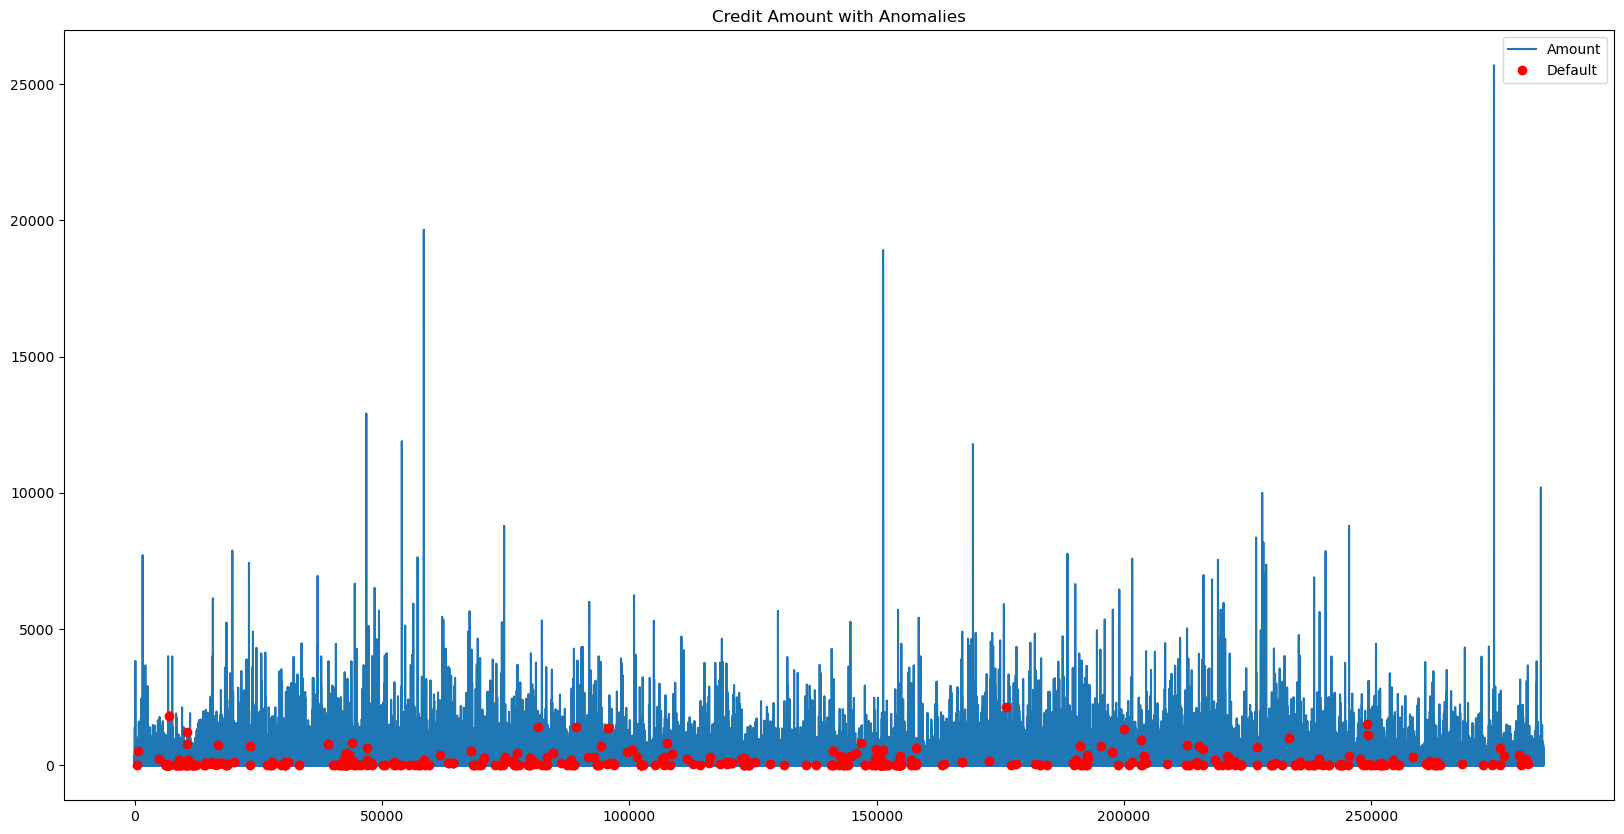

In [8]:
plt.figure(figsize=(20, 10))

value = df['Amount']
anomalies = df['Class']

indices = range(len(value))
anomalies_indices = [i for i in df[df['Class']==1].index]

plt.plot(indices, value, label='Amount')
plt.plot( anomalies_indices, value[anomalies_indices], "ro", label='Default')
plt.title('Credit Amount with Anomalies')
plt.legend()

# Feature Engineering: 

In [9]:
# Number of transaction each second (w.r.t. the order of the time series)

df['transactions_seconds']=1

for i in range(1, len(df)):
    t = df.loc[i, 'Time']
    t1 = df.loc[i-1, 'Time']
    if t==t1:
        df.loc[i, 'transactions_seconds'] = df.loc[i-1, 'transactions_seconds'] + 1

In [10]:
# Training will be composed of 60% of the dataset

train_size = int(0.6*len(df))

train = df.iloc[:train_size]
test = df.iloc[train_size:]

In [11]:
# Normalizing the Amounts

scaler = StandardScaler()

train = train.copy()
test = test.copy()

train['Amount'] = scaler.fit_transform(train['Amount'].values.reshape(-1, 1))
test['Amount'] = scaler.transform(test['Amount'].values.reshape(-1, 1))

# Training a classifier using supervised learning:

In [42]:
BATCH_SIZE=256
EPOCHS=2
LR=1e-3
DEVICE="cuda"

In [43]:
trainset = Dataset(train)
testset = Dataset(test)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

model = Classifier().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [45]:
for epoch in range(EPOCHS):
    epoch_loss = 0
    batch_pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{EPOCHS} Batches", leave=False)  # Inner progress bar for batches
    for inputs, targets in batch_pbar:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        preds = model(inputs)
        preds = torch.squeeze(preds, dim=1)
        targets = targets.float()
        loss = criterion(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Optionally update the inner pbar with the current loss
        batch_pbar.set_postfix(loss=loss.item())

    # Optionally update the outer pbar with the epoch loss
    print(f"epoch loss : {loss.item()/len(trainloader)}")

epoch loss : 1.7171960552697053e-06


epoch loss : 1.2434392848224965e-06


In [50]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        preds = model(test_batch).squeeze()
        preds = torch.sigmoid(preds)
        all_preds.append(preds.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score}")

100%|██████████| 446/446 [00:20<00:00, 21.91it/s]

ROC-AUC score: 0.9542218282694244


In [51]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

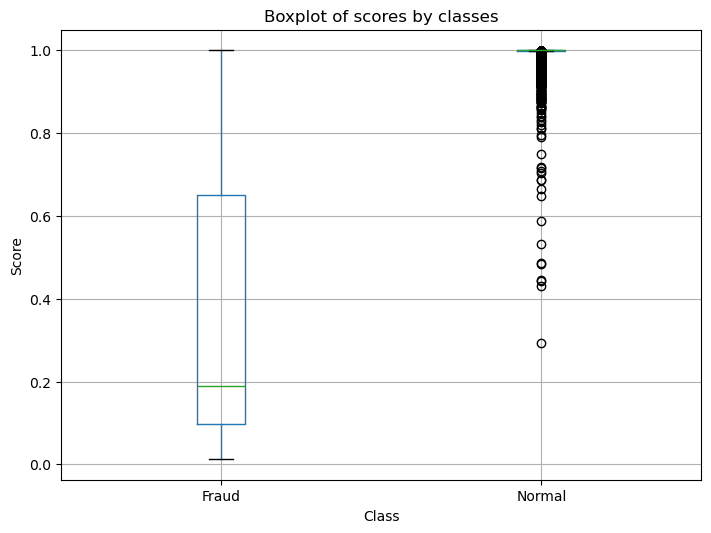

In [53]:
results.boxplot(column='pred', by='class', figsize=(8, 6))

plt.title("Boxplot of scores by classes")
plt.suptitle("") 
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

plt.show()

# Training a classifier using unsupervised learning with SGD OneClassSVM:

In [12]:
train_size = int(0.6*len(df))

train = df.iloc[:train_size]
test = df.iloc[train_size:]

train = train[train['Class']==0]

df = pd.concat([train, test])
df = df.reset_index(drop=True)

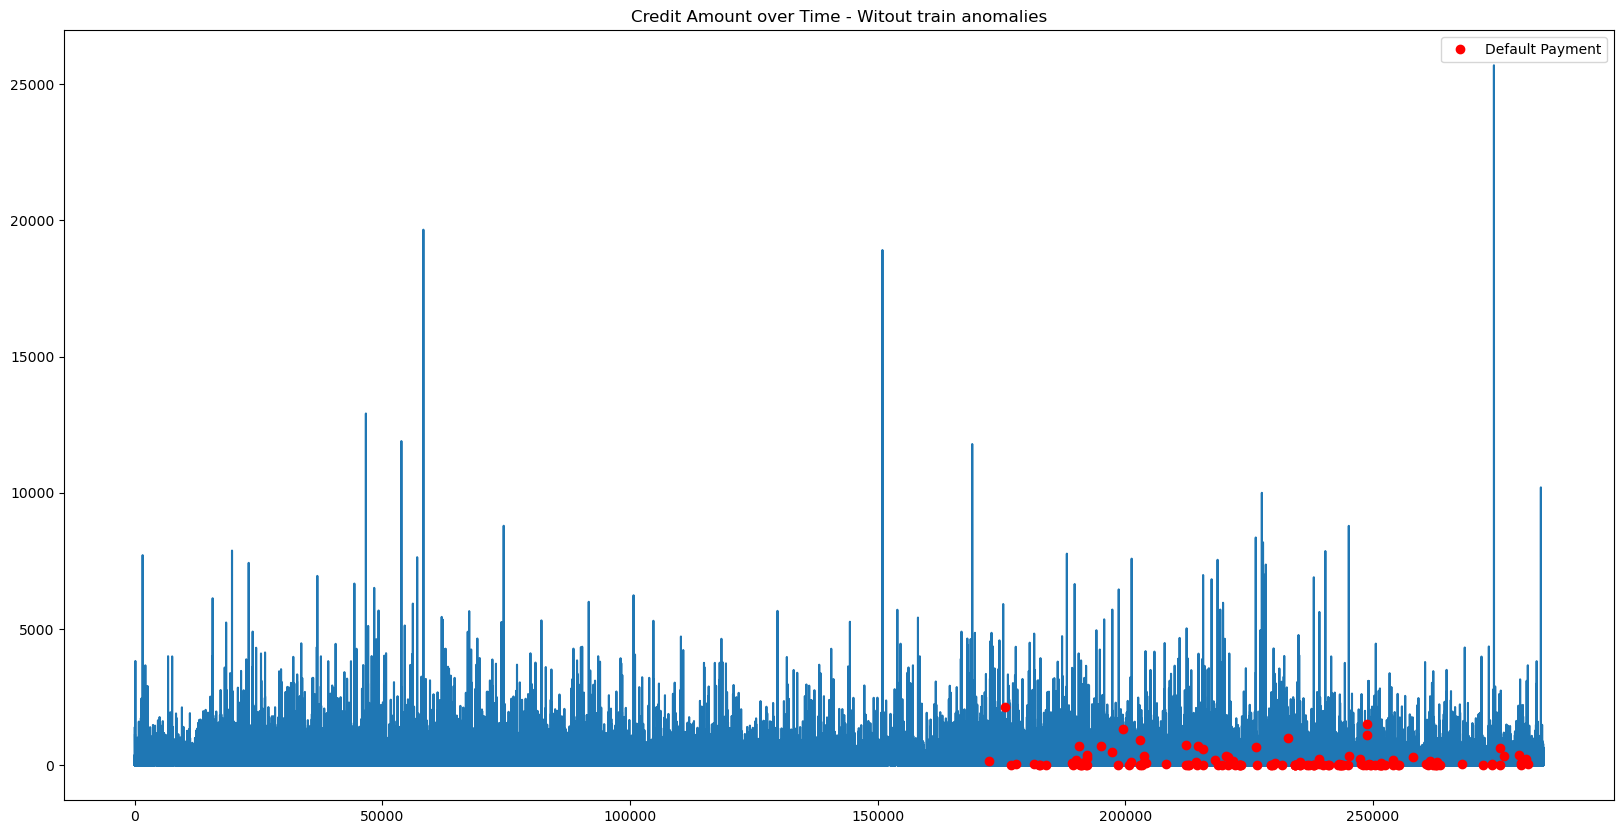

In [13]:
plt.figure(figsize=(20, 10))

value = df['Amount']
anomalies = df['Class']

indices = range(len(value))
anomalies_indices = [i for i in df[df['Class']==1].index]

plt.plot(indices, value)
plt.plot( anomalies_indices, value[anomalies_indices], "ro", label="Default Payment")
plt.title("Credit Amount over Time - Witout train anomalies")
plt.legend()

In [14]:
scaler = StandardScaler()

train, test = train.copy(), test.copy()

train['Amount'] = scaler.fit_transform(train['Amount'].values.reshape(-1, 1))
test['Amount'] = scaler.transform(test['Amount'].values.reshape(-1, 1))

In [20]:
X_train = train.drop(['Time', 'Class'], axis=1)
X_test = test.drop(['Time', 'Class'], axis=1)
y_test = test['Class']

In [ ]:
clf = SGDOneClassSVM().fit(X_train)
prediction = clf.predict(X_test)

prediction = clf.predict(X_test)
prediction = np.where(prediction == -1, 1, 0)

score = roc_auc_score(y_test, prediction)
print(f"ROC-AUC score: {score}")

ROC-AUC score: 0.5678059296908766


# Training a classifier using unsupervised learning with DROCC:

In [32]:
train_size = int(0.6*len(df))

train = df.iloc[:train_size]
test = df.iloc[train_size:]

train = train[train['Class']==0]

df = pd.concat([train, test])
df = df.reset_index(drop=True)

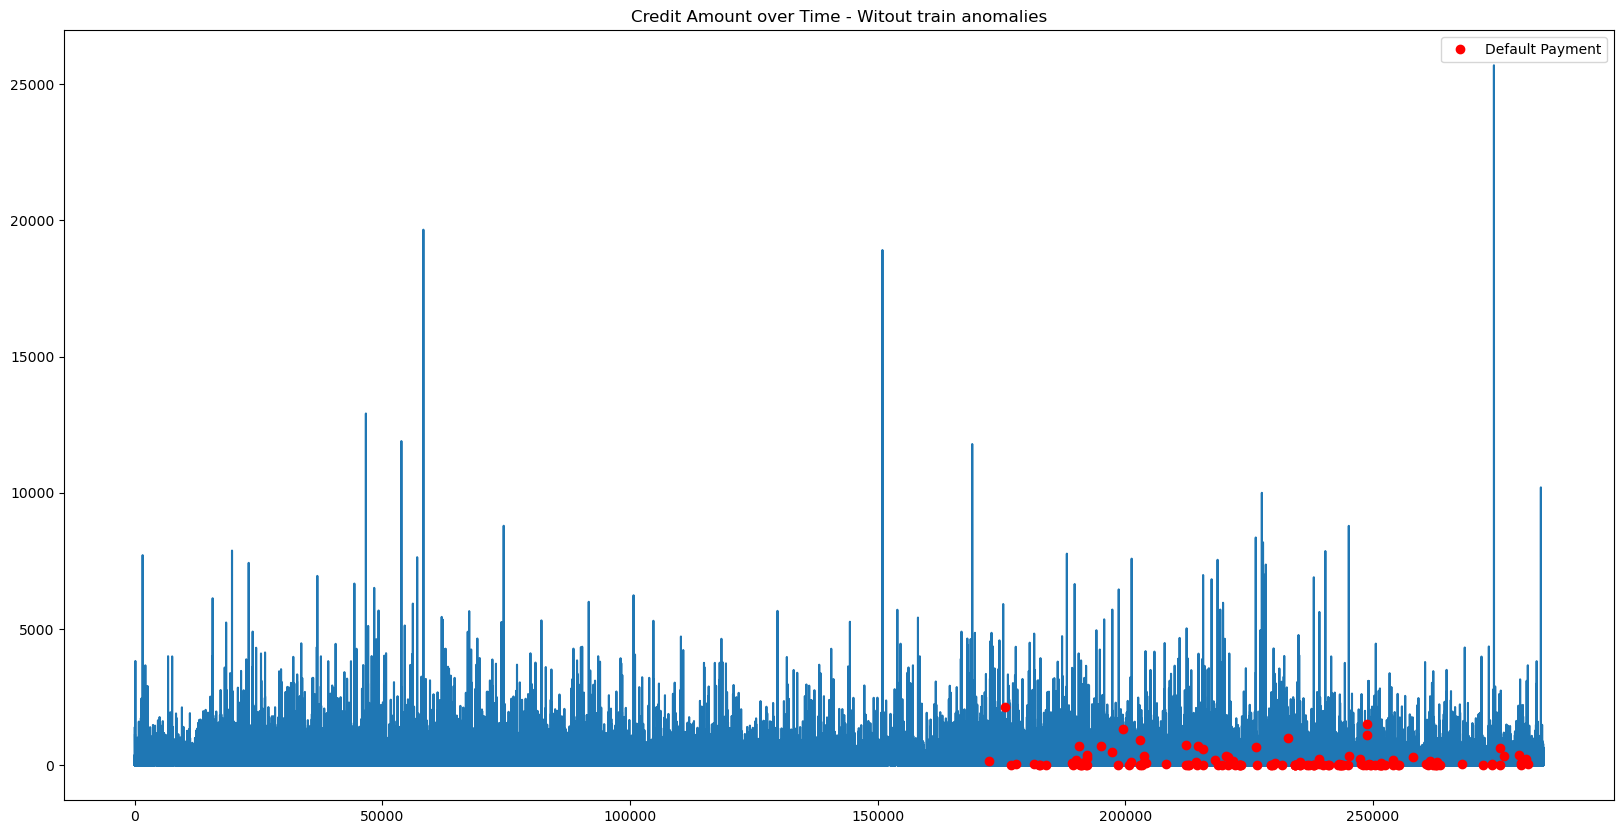

In [33]:
plt.figure(figsize=(20, 10))

value = df['Amount']
anomalies = df['Class']

indices = range(len(value))
anomalies_indices = [i for i in df[df['Class']==1].index]

plt.plot(indices, value)
plt.plot( anomalies_indices, value[anomalies_indices], "ro", label="Default Payment")
plt.title("Credit Amount over Time - Witout train anomalies")
plt.legend()

In [34]:
scaler = StandardScaler()

train, test = train.copy(), test.copy()

train['Amount'] = scaler.fit_transform(train['Amount'].values.reshape(-1, 1))
test['Amount'] = scaler.transform(test['Amount'].values.reshape(-1, 1))

In [35]:
LR=1e-3
EPOCHS=4
BATCH_SIZE=256

CE_EPOCHS=1
ASCENT_STEP_SIZE=0.1
ASCENT_NUM_STEPS=50

GAMMA=2
LAMBDA=1
RADIUS=10

DEVICE="cuda"

In [36]:
trainset = Dataset(train)
testset = Dataset(test)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

model = Classifier().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [37]:
trainer = DROCCTrainer(model, optimizer, lamda=LAMBDA, radius=RADIUS, gamma=GAMMA, device=DEVICE)
trainer.train(trainloader, learning_rate=LR, lr_scheduler=adjust_learning_rate, total_epochs=EPOCHS,
             ascent_step_size=ASCENT_STEP_SIZE, ascent_num_steps=ASCENT_NUM_STEPS, only_ce_epochs = CE_EPOCHS)

model = trainer.model

100%|██████████| 667/667 [00:31<00:00, 21.23it/s]


Epoch: 0, CE Loss: 0.03030557371675968, AdvLoss: 0.0


100%|██████████| 667/667 [00:47<00:00, 14.00it/s]


Epoch: 1, CE Loss: 0.503766655921936, AdvLoss: 0.6614258885383606


100%|██████████| 667/667 [00:48<00:00, 13.64it/s]


Epoch: 2, CE Loss: 0.1686238944530487, AdvLoss: 0.10152274370193481


100%|██████████| 667/667 [00:49<00:00, 13.51it/s]

Epoch: 3, CE Loss: 0.1524486392736435, AdvLoss: 0.09551071375608444


In [41]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        preds = torch.sigmoid(model(test_batch).squeeze())
        all_preds.append(preds.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score}")

100%|██████████| 446/446 [00:22<00:00, 19.72it/s]

ROC-AUC score: 0.9553591472723919


In [42]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

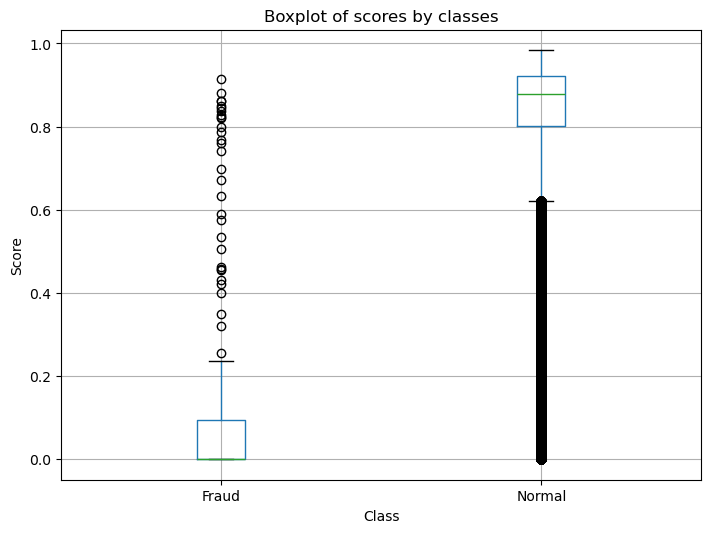

In [43]:
results.boxplot(column='pred', by='class', figsize=(8, 6))

# Ajouter des labels et un titre
plt.title("Boxplot of scores by classes")
plt.suptitle("")  # Supprime le titre automatique de pandas
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

# Afficher le graphique
plt.show()